# Goal

* Create simple langgraph to convert entrez IDs to SRX accessions

# Init

In [7]:
# import 
import os
import re
import time
import operator
from enum import Enum
from pprint import pprint
from datetime import datetime, timedelta
from typing import Annotated, List, Dict, Tuple, Optional, Union, Any, Sequence, TypedDict
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from pydantic import BaseModel, Field
from langchain_core.tools import tool
from Bio import Entrez
import pandas as pd
from dotenv import load_dotenv

In [11]:
from SRAgent.agents.entrez import create_entrez_agent
from SRAgent.agents.utils import create_step_summary_chain
from SRAgent.tools.convert import geo2sra

In [2]:
# setup
load_dotenv()
pd.set_option('display.max_colwidth', 1000)
os.environ["DEBUG_MODE"] = "TRUE"

In [3]:
# checks
if os.getenv("DEBUG_MODE") == "TRUE":
    print("DEBUG_MODE is enabled.")

DEBUG_MODE is enabled.


In [13]:
# set up Entrez
Entrez.email = "nick.youngblut@arcinstitute.org"

# State

In [66]:
class GraphState(TypedDict):
    """
    Shared state of the agents in the graph
    """
    entrez_id: Annotated[str, "Entrez ID"]
    messages: Annotated[Sequence[BaseMessage], operator.add, "Messages"]
    SRX: Annotated[List[str], operator.add, "SRX accessions"]
    route: Annotated[str, "Route"]
    round: Annotated[int, "Round"]

# Nodes

In [55]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

In [56]:
# invoke entrez agent
def create_entrez_agent_node(state: GraphState):
    entrez_agent = create_entrez_agent()
    entrez_id = state["entrez_id"]
    prompt = ChatPromptTemplate.from_messages([
        MessagesPlaceholder(variable_name="history"),
        ("human", f"Obtain all SRX accessions for the Entrez ID {entrez_id}")
    ])
    formatted_prompt = prompt.format_messages(
        history=state["messages"][-3:]
    )
    return entrez_agent.invoke({"messages" : formatted_prompt})

state = {
    "entrez_id" : "34748561",
    "messages" : []
}
# entrez_agent_node = create_entrez_agent_node(state)

In [57]:
class Acessions(BaseModel):
    srp: List[str]
    srx: List[str]
    srr: List[str]

def create_get_accessions_node(state: GraphState):
    """
    Structured data extraction
    """
    message = state["messages"][-1].content
    prompt = "\n".join([
        "SRX accessions from the Sequence Read Archive start with the 'SRX' prefix.",
        f"Extract SRX accessions from the following:",
        message
    ])
    model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)
    response = model.with_structured_output(Acessions, strict=True).invoke(prompt)
    return {"SRX" : response.srx}

state = {
    "messages" : [
        HumanMessage(
            content=" - **Study Accession**: SRP526682\n- **Sample Accession**: SRS22358714- **Run Accession**: SRR30256648\n**Experiment Accession**: SRX4967528"
        )
    ]
}
# create_get_accessions_node(state)

In [59]:
# router
model = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

class Choices(Enum):
    CONTINUE = "Continue"
    STOP = "Stop"

class Choice(BaseModel):
    Choice: Choices

def create_router_node(state: GraphState):
    """
    Router for the graph
    """
    # create prompt
    prompt = ChatPromptTemplate.from_messages([
        # First add any static system message if needed
        ("system", "You determine whether Sequence Read Archive SRX accessions have been obtained from the Entrez ID."),
        ("system", "Here are the last few messages:"),
         MessagesPlaceholder(variable_name="history"),
        # Add the final question/instruction
        ("human", "Based on the messages above, select STOP if the task is complete or CONTINUE if more information is needed."),
    ])
    formatted_prompt = prompt.format_messages(history=state["messages"])
    # call the model
    response = model.with_structured_output(Choice, strict=True).invoke(formatted_prompt)
    return {"route": response.Choice.value, "rounds": 1}

# Graph

In [60]:
from langgraph.graph import START, END, StateGraph, MessagesState

In [62]:
def route_interpret(state: GraphState) -> str:
    """
    Determine the route based on the current state of the conversation.
    """
    if state["rounds"] >= 2:
        return END
    return "entrez_agent_node" if state["route"] == "Continue" else END

In [63]:
#-- graph --#
workflow = StateGraph(GraphState)

# nodes
workflow.add_node("entrez_agent_node", create_entrez_agent_node)
workflow.add_node("get_accessions_node", create_get_accessions_node)
workflow.add_node("router_node", create_router_node)

# edges
workflow.add_edge(START, "entrez_agent_node")
workflow.add_edge("entrez_agent_node", "get_accessions_node")
workflow.add_edge("get_accessions_node", "router_node")
workflow.add_conditional_edges("router_node", route_interpret)

# compile the graph
graph = workflow.compile()

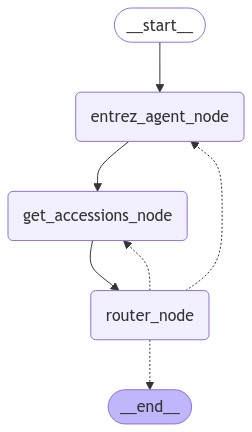

In [64]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [65]:
input = {"entrez_id" : "34748561"}
for step in graph.stream(input, config={"max_concurrency" : 3, "recursion_limit": 30}):
    print(step)
    final_step = step

{'entrez_agent_node': {'messages': [HumanMessage(content='Obtain all SRX accessions for the Entrez ID 34748561', additional_kwargs={}, response_metadata={}, id='e767a6a7-35b0-48be-b876-75cd7ce2dd5a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ScwmL6nXQ1RqIQBDT2EjyB1p', 'function': {'arguments': '{"message":"Fetch the SRX accessions for Entrez ID 34748561"}', 'name': 'invoke_efetch_worker'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 954, 'total_tokens': 984, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_a7d06e42a7', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-28014756-fbf2-4339-b9b6-acd7e4a7378f-0', tool_calls=[{'name': 'invoke_efetch_worker', 'args': {'me